# Efficient Frontier

Park Street Ventures LLC

Subu Sangameswar

May 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

/Users/sangames/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import PSVLib as lib

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one assets. 

### Efficient Frontiers 

In the MPT, the **efficient frontier** is an a curve which occupies the **efficient** part of the **volatility-return plane**. 
Formally, it is the set of portfolios that can be constructed with the given input assets 
that have the maximum expected returns for a fixed level of volatility and, in turn, 
the lowest volatilities for a fixed level of expected return. The efficient frontier was first formulated by **Harry Markowitz** (1952).

We have to construct a portfolio of several assets and **we want to find the optimal percentages of investment to be allocated in these assets** so that, for example, the total (expected) return of such a portfolio is maximixed for a given level of volatility. 

and we set up $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [5]:
# get few stocks
tickers  = ['AAPL','MSFT','SBUX']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2010,1,1), end=datetime(2020,4,15))["Adj Close"]    

In [6]:
stocks.tail()

,AAPL,MSFT,SBUX
Date,,,
2020-04-08,266.070007,165.130005,71.570000
2020-04-09,267.989990,165.139999,73.879997
2020-04-13,273.250000,165.509995,71.760002
2020-04-14,287.049988,173.699997,73.669998
2020-04-15,284.429993,171.880005,72.550003


In [7]:
# compute the daily returns 
daily_rets = lib.compute_returns(stocks)
daily_rets.tail()

,AAPL,MSFT,SBUX
Date,,,
2020-04-08,0.025595,0.010031,0.041624
2020-04-09,0.007216,0.000061,0.032276
2020-04-13,0.019628,0.002240,-0.028695
2020-04-14,0.050503,0.049483,0.026616
2020-04-15,-0.009127,-0.010478,-0.015203


In [8]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

,AAPL,MSFT,SBUX
AAPL,0.000303,0.000148,0.000127
MSFT,0.000148,0.000248,0.000133
SBUX,0.000127,0.000133,0.000269


Now we simulate $1000$ portfolios with weights allocated to the stocks above:

In [9]:
periods_per_year = 252
num_portfolios   = 1000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3"])
risk_free_rate   = 0

In [10]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    ann_rets      = lib.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = lib.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = lib.portfolio_volatility(weights, cov_rets)
    portfolio_vol = lib.annualize_vol(portfolio_vol, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = lib.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2]}, 
                                     ignore_index=True)

Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier:

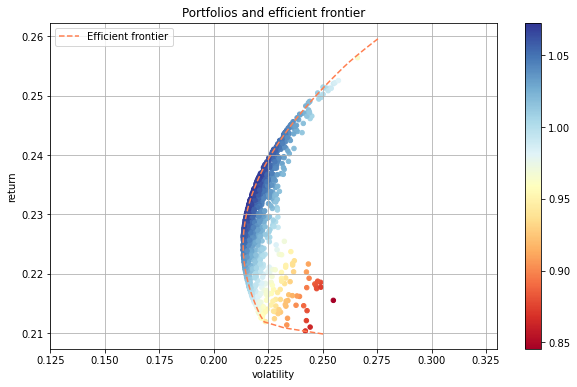

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df = lib.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.set_xlim([0.125,0.33])

fig.colorbar(im, ax=ax)
plt.show()

**We will come back to the plot of the efficient frontier below**.

We can see that if the investor is targeting **a return of $20\%$** he could simply hold 
a portfolio **with volatility of about $17.5\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $22.5\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are **two important** portfolios:

1. the **portfolio with the Global Minimum Volatility (GMV)**, i.e., the global minimum variance portfolio
2. the **portfolio with the Maximum Sharpe Ratio (MSR)**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [12]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]
print("Global Minimum Volatility portfolio:")
print("- return      : {:.2f}%".format(low_vol_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(low_vol_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(low_vol_portfolio[2]) )

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]
print("\Maximum Sharpe Ratio portfolio:")
print("- return      : {:.2f}%".format(high_sharpe_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(high_sharpe_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(high_sharpe_portfolio[2]) )

Global Minimum Volatility portfolio:
- return      : 22.49%
- volatility  : 21.35%
- sharpe ratio: 1.05
\Maximum Sharpe Ratio portfolio:
- return      : 23.36%
- volatility  : 21.77%
- sharpe ratio: 1.07


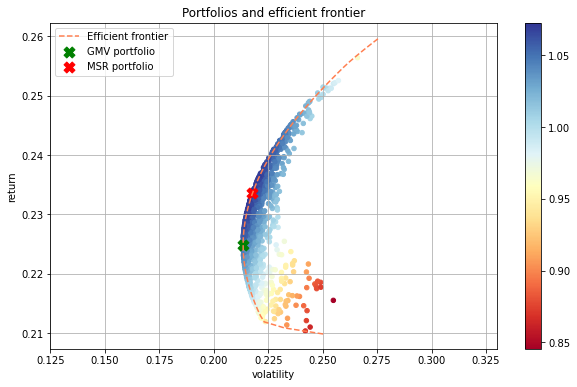

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, label=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()

# Draw the efficient frontier
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")

ax.scatter(low_vol_portfolio[1],     low_vol_portfolio[0],     marker="X", color='g', s=120, label="GMV portfolio")
ax.scatter(high_sharpe_portfolio[1], high_sharpe_portfolio[0], marker="X", color='r', s=120, label="MSR portfolio")

ax.set_xlim([0.125,0.33])
ax.legend()

fig.colorbar(im, ax=ax)
plt.show()

In [36]:
# utility function

def get_portfolio_features(weights, rets, covmat, risk_free_rate, periods_per_year):
    # portfolio volatility
    vol = lib.portfolio_volatility(weights, covmat)
    vol = lib.annualize_vol(vol, periods_per_year)

    # portfolio return
    ret = lib.portfolio_return(weights, rets)

    # portfolio sharpe ratio
    shp = lib.sharpe_ratio(ret, risk_free_rate, periods_per_year, v=vol)

    print("Portfolio return:       {:.2f}%" .format(ret*100))
    print("Portfolio volatility:   {:.2f}%" .format(vol*100))
    print("Portfolio sharpe ratio: {:.2f}" .format(shp))
    
    return ret, vol, shp

def print_weights(tickers, weights):
    print("optimal weights:")
    for i in range(len(tickers)):
        print("{0} :{1:.2f}%".format(tickers[i], weights[i]*100))

### Finding the optimal portfolios: minimizing the volatility 

In the experiments above, we found the optimal portfolios, i.e., the ones on the efficient frontier, by **simulating a high number of portfolios** and then plotting them. From the plot we could see what the efficient frontier looked like. 
However, we can find an optimal portfolio on the efficient frontier by **solving a minimization problem**, 
for example, by applying the **scipy optimize** method. 


For example, suppose we want to **find the portfolio (on the efficient frontier) which has the minimum volatility**. 
Then the minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

In [15]:
# Let us see the total (annual) returns of single companies we are investing in
ann_rets = lib.annualize_rets(daily_rets, periods_per_year)
ann_rets

AAPL    0.259805
MSFT    0.209872
SBUX    0.215395
dtype: float64

Now, we can call our minimizer which solves the minimization problem of finding the weights of the portfolio with minimum volatility. 

In [38]:
optimal_weights = lib.minimize_volatility(ann_rets, cov_rets)
print_weights(tickers, optimal_weights)

optimal weights:
AAPL :33.33%
MSFT :33.33%
SBUX :33.33%


Let us compute the volatility of the portfolio constructed with these weights and locate it on the efficient frontier:

Portfolio return:       22.84%
Portfolio volatility:   21.42%
Portfolio sharpe ratio: 1.07


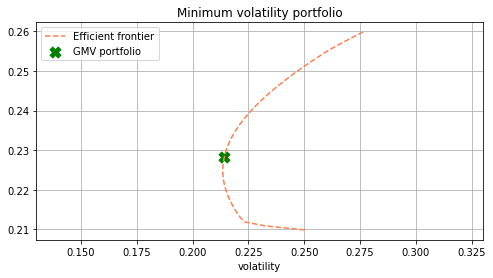

In [17]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = lib.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='g', s=120, label="GMV portfolio")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum volatility portfolio")
plt.show()

We can also verify that the minimum volatility portfolio obtained by solving the minimization problem almost coincides 
with the one obtained from simulating a high number of portfolios as we have done before: 

In [18]:
print("GMV portfolio:\n")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(low_vol_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(low_vol_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(low_vol_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

GMV portfolio:

- Monte carlo:
  return:       22.49%
  volatility:   21.35%
  sharpe ratio: 1.05

- Minimization problem:
  return:       22.84%
  volatility:   21.42%
  sharpe ratio: 1.07


#### Finding the optimal portfolios: minimizing the volatility given a fixed return

What if we want to find the **portfolio (on the efficient frontier) with minimium volatility for a given a level of return**? 
In this case, we simply have to add a constrain in the minimization problem:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $R_0$ denotes a fixed level of expected return. For example, suppose we target the following total expected return $R_0=16\%$:

In [20]:
target_return = 0.16

Now, we can call again the minimizer with the option of solving the problem with the constrain for the given target return:

In [39]:
optimal_weights = lib.minimize_volatility(ann_rets, cov_rets, target_return)
print_weights(tickers, optimal_weights)

optimal weights:
AAPL :0.00%
MSFT :100.00%
SBUX :0.00%


Let us compute the volatility of the portfolio constructed with these weights. 
Also, we double check that the corresponding return is the target return that we have chosen (i.e., $16\%$) and 
locate the portfolio on the efficient frontier:

Portfolio return:       20.99%
Portfolio volatility:   25.02%
Portfolio sharpe ratio: 0.84


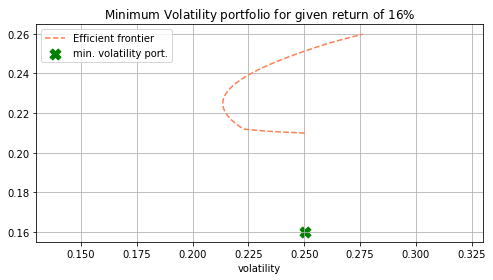

In [22]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = lib.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, target_return,  marker="X", color='g', s=120, label="min. volatility port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Minimum Volatility portfolio for given return of $16\%$")
plt.show()

Recall that **the return of a portfolio will be some value between the minimum and the maximum return from the assets composing the portfolio**. That is, given the same three companies, we cannot achieve a return of, say $40\%$ since the maximum return achievable is about $30\%$ from Amazon. 
In fact, if we run the minimizer with a target return equal to $40\%$ we will get zero weights to all assets but Amazon:

In [40]:
optimal_weights = lib.minimize_volatility(ann_rets, cov_rets, 0.4)
print_weights(tickers, optimal_weights)

optimal weights:
AAPL :100.00%
MSFT :0.00%
SBUX :0.00%


### Finding the optimal portfolios: maximizing the sharpe ratio 

Now, consider the case of finding **the portfolio (on the efficient frontier) with the highest sharpe ratio**. 

Note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conclude 
that we are not able to find such a portfolio by solving an optimization problem. 
However, **the maximization of the sharpe ratio is nothing but the minimization of the negative sharpe ratio**. 
That is, we have 
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

Let us use our minimizer:

In [41]:
optimal_weights = lib.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print_weights(tickers, optimal_weights)

optimal weights:
AAPL :50.00%
MSFT :20.60%
SBUX :29.39%


Portfolio return:       23.33%
Portfolio volatility:   21.75%
Portfolio sharpe ratio: 1.07


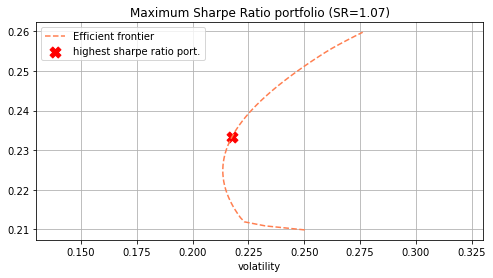

In [25]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = lib.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highest sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Maximum Sharpe Ratio portfolio (SR={:.2f})".format(shp))
plt.show()

and let us see how these numbers differ from those obtained from the Monte Carlo simulation:

In [26]:
print("MSR portfolio:\n")
print("- Monte carlo:")
print("  return:       {:.2f}%" .format(high_sharpe_portfolio[0]*100))
print("  volatility:   {:.2f}%" .format(high_sharpe_portfolio[1]*100))
print("  sharpe ratio: {:.2f}" .format(high_sharpe_portfolio[2]))
print("\n- Minimization problem:")
print("  return:       {:.2f}%" .format(ret*100))
print("  volatility:   {:.2f}%" .format(vol*100))
print("  sharpe ratio: {:.2f}" .format(shp))

MSR portfolio:

- Monte carlo:
  return:       23.36%
  volatility:   21.77%
  sharpe ratio: 1.07

- Minimization problem:
  return:       23.33%
  volatility:   21.75%
  sharpe ratio: 1.07


#### Finding the optimal portfolios: maximize the sharpe ratio given a fixed volatility 

Similarly to what we have done before, we can find the **portfolio (on the efficient frontier) with highest sharpe ratio 
for a given a level of volatility**. In this case, we simply add a constrain in the minimization problem:
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: \text{SR} 
$$
subject to 
$$
\begin{cases}
\frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} = \sigma_0, \\
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$
where $\sigma_0$ denotes a fixed level of volatility. For example, suppose we target the following total volatility of $\sigma_0=20\%$:

In [42]:
target_volatility = 0.2
optimal_weights = lib.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year, target_volatility)
print_weights(tickers, optimal_weights)

optimal weights:
AAPL :25.97%
MSFT :37.96%
SBUX :36.07%


Portfolio return:       22.48%
Portfolio volatility:   21.35%
Portfolio sharpe ratio: 1.05


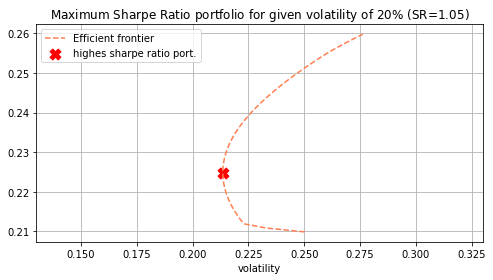

In [29]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

# Draw the efficient frontier
fig, ax = plt.subplots(1,1, figsize=(8,4)) 
df = lib.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient frontier")
ax.scatter(vol, ret,  marker="X", color='r', s=120, label="highes sharpe ratio port.")
ax.set_xlim([0.13,0.33])
ax.legend()
ax.set_title("Maximum Sharpe Ratio portfolio for given volatility of $20\%$ (SR={:.2f})".format(shp))
plt.show()

### Observation on constraints

It is worth mentioning that so far we have decided to invest all of our capital and, at the same time, our strategy has been **long-only**. That is, the weights that we allocate to the assets sum to $1$ 
and all of them are positive (because we **buy** the assets). 
In particular, these two conditions were imposed when solving the minimization problems. 

However, **we could in principle not invest all of our capital**, which means that we at do not necessarily 
get weights that sum to $1$, and also we may decide to not buy all the assets. We could **short selling** some of them (by short shelling we mean selling an asset that we do not have and that we borrow from someone else).

 

### Maximizing the sharpe ratio portfolio in presence of non null risk-free rate

Recall that a **risk-free asset** is an (hypothetical) asset with a risk-free rate. For example, **short-term government securities (such as US treasury bills)** are used as a risk-free asset since **they pay a fixed interest rate and have exceptionally low default risk**. 

The risk-free asset has zero volatility. Furthermore, it is also uncorrelated with any other asset since, 
by definition, its volatility is zero. Therefore, when combined with any other asset in a portfolio, 
**the change in return is linearly related to the change in risk** as the proportions in the combination vary.

#### The capital market line (CML)

When a risk-free asset is introduced, there will be a line satisfying:

 1. it is tangent to the curve at the risky portfolio with the highest Sharpe ratio; 
 2. its vertical intercept represents a portfolio with $100\%$ of holdings in the risk-free asset; 
 3. the tangency with the curve represents the highest sharpe ratio portfolio with no risk-free holdings and $100%$ of risky assets; 
 assets held in the portfolio occurring at the tangency point; 
 4. points on this line represent portfolios containing positive amounts of both the risky assets and the risk-free asset; 
 
This efficient line is called the **Capital Market Line (CML)**, and its given by:
$$
R_{CML} = R_{f} + \sigma_{CML}\frac{R_{p} - R_{f}}{\sigma_{p}}, 
$$
where $R_p$ and $\sigma_p$ are the return and the volatility of the risky portfolio with no risk free asset, respectively, 
$R_f$ denotes the risk-free rate, and $R_{CML}$ and $\sigma_{CML}$ denote the return and the volatility of the 
portfolio combining both risky assets and the risk-free asset, respectively.

In [43]:
risk_free_rate = 0.06
optimal_weights = lib.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
print_weights(tickers, optimal_weights)

optimal weights:
AAPL :50.00%
MSFT :20.60%
SBUX :29.39%


In [32]:
ret, vol, shp = get_portfolio_features(optimal_weights, ann_rets, cov_rets, risk_free_rate, periods_per_year)

Portfolio return:       24.74%
Portfolio volatility:   23.03%
Portfolio sharpe ratio: 0.81


Let us plot the efficient frontier and the capital market line using the optional argument in our plot method:

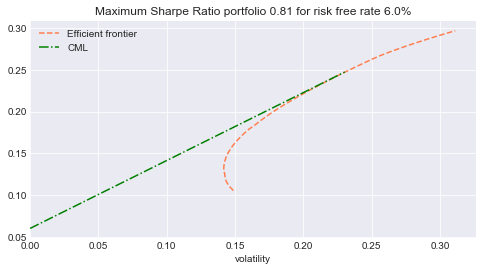

In [33]:
df, ax = lib.efficient_frontier(40, daily_rets, cov_rets, periods_per_year, risk_free_rate=risk_free_rate, 
                                iplot=True, cml=True)
ax.set_title("Maximum Sharpe Ratio portfolio {} for risk free rate {}%".format(np.round(shp,2),risk_free_rate*100))
plt.show()

The introduction of the risk-free asset as a possible component of the portfolio has improved the range of volatility-return combinations available since **everywhere, except at the tangency portfolio, the CML provides a higher return than the (old) efficient frontier does 
at every possible volatility.** 

Note that the efficient frontier method has other optional parameter to plot the highest sharpe ratio, the minimum volatility, and the equally weigthed portfolio as well:

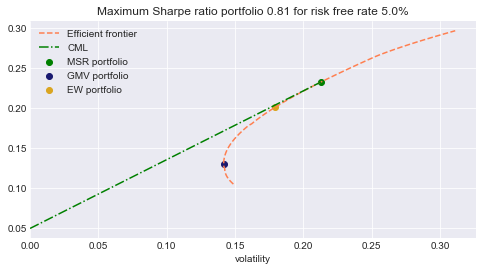

In [34]:
risk_free_rate = 0.05
df, ax = lib.efficient_frontier(90, daily_rets, cov_rets, periods_per_year, risk_free_rate=risk_free_rate, 
                                iplot=True, hsr=True, cml=True, mvp=True, ewp=True)
ax.set_title("Maximum Sharpe ratio portfolio {} for risk free rate {}%".format(np.round(shp,2),risk_free_rate*100))
plt.show()

In [35]:
df.tail()

,0,1,2,3,4,5
88,0.306585,0.294691,0.798117,0.977343,1.110223e-16,0.022657
89,0.311073,0.296842,0.793521,1.000000,8.588914e-18,0.000000
90,0.212923,0.232931,0.859140,0.483833,1.543181e-01,0.361849
91,0.141678,0.130930,0.571223,0.055688,7.898496e-01,0.154462
92,0.179320,0.201360,0.844078,0.333333,3.333333e-01,0.333333


### Maximizing the sharpe ratio = Minimizing volatility when we invest also in a risk free asset


First of all, recall that with our method we can find the weigths of the portfolio with the maximum sharpe ratio:

In [36]:
risk_free_rate = 0.06
optimal_weights = lib.maximize_shape_ratio(ann_rets, cov_rets, risk_free_rate, periods_per_year)
optimal_weights

array([0.54475795, 0.06430902, 0.39093302])

Ok. Let us verify our formulas for $\mathbf{w}_M$:

In [38]:
invcov = lib.inverse_df(cov_rets)
ones   = np.repeat(1,3) 
r_rf   = ann_rets - risk_free_rate*ones

In [39]:
w_M = np.dot( invcov, r_rf ) / np.dot( ones, np.dot(invcov, r_rf) )
w_M

array([0.54341316, 0.06476746, 0.39181938])

Yes, they coincide. We implemented these weights in the following method:

In [40]:
lib.weigths_max_sharpe_ratio(cov_rets, r_rf).values

array([0.54341316, 0.06476746, 0.39181938])

Now, let us verify that the portfolio with these weigths has a return and a volatility as in formulas $\mu_M$ and $\sigma_M$:

In [41]:
# return: using the portfolio return method
mu_M = lib.portfolio_return(w_M, ann_rets)
mu_M

0.24723259196553926

In [42]:
# return: using the formula we found
mu_M = np.dot( r_rf, np.dot(invcov, ann_rets) ) / np.dot(ones, np.dot(invcov,r_rf) )
mu_M 

0.24723259196553932

In [44]:
# volatility: using the portfolio vol method
sigma_M = lib.annualize_vol( lib.portfolio_volatility(w_M, cov_rets), periods_per_year)
sigma_M

0.23005214107788935

In [45]:
# volatility: using the formula
sigma_M = np.sqrt( np.dot(r_rf, np.dot(invcov,r_rf)) ) / np.dot(ones, np.dot(invcov,r_rf))
sigma_M = lib.annualize_vol(sigma_M , periods_per_year)
sigma_M

0.23005214107788935

Perfect. Let us now define the $\mathbf{w}^*$ weigths of a portfolio which invest in both the risk-free asset and risky assets:

In [46]:
target_ret = 0.13
wstar = (target_ret - risk_free_rate) / np.dot(r_rf, np.dot(invcov,r_rf)) * np.dot(invcov,r_rf)             
wstar

array([0.20316399, 0.02421438, 0.14648815])

To these weigths we have to add the weigth in the risk-free asset:

In [47]:
np.append( wstar, 1-wstar.sum() )

array([0.20316399, 0.02421438, 0.14648815, 0.62613347])

The last weight is the one in the risk-free asset. 
The return of such a portfolio is, by definition, equal to the target return:

In [48]:
mu_p = lib.portfolio_return( np.append(wstar,1-wstar.sum()) , ann_rets.append(pd.Series(risk_free_rate)) )
mu_p

0.13

Let us see the volatility of such a portfolio:

In [50]:
# using the portfolio_volatility method
lib.annualize_vol( lib.portfolio_volatility(wstar, cov_rets), periods_per_year)

0.08600879636605244

In [51]:
# using the formula
sigma_p = lib.annualize_vol( (target_ret - risk_free_rate) / np.sqrt(np.dot(r_rf, np.dot(invcov,r_rf))), periods_per_year )
sigma_p

0.08600879636605244

Finally, let us verify that all portfolio that are constructed using the weigths $\mathbf{w}^*$ and $1-\mathbf{w}^T\mathbf{1}$ lie on the Capital Market Line. We define a set of target returns, from the original target return of $0.06$ up to the maximum sharpe ratio return $\mu_M$:

In [52]:
target_ret_vec = np.linspace(target_ret,mu_M,20)
wstar = [ (tr - risk_free_rate) / np.dot(r_rf, np.dot(invcov,r_rf)) * np.dot(invcov,r_rf) for tr in target_ret_vec ]         
wstar = [ np.append(wstar[i], 1-wstar[i].sum()) for i in range(len(wstar)) ]
wstar 

[array([0.20316399, 0.02421438, 0.14648815, 0.62613347]),
 array([0.22107185, 0.02634876, 0.15940032, 0.59317907]),
 array([0.2389797 , 0.02848313, 0.17231249, 0.56022468]),
 array([0.25688755, 0.0306175 , 0.18522466, 0.52727029]),
 array([0.2747954 , 0.03275187, 0.19813683, 0.4943159 ]),
 array([0.29270325, 0.03488625, 0.211049  , 0.4613615 ]),
 array([0.3106111 , 0.03702062, 0.22396117, 0.42840711]),
 array([0.32851895, 0.03915499, 0.23687334, 0.39545272]),
 array([0.3464268 , 0.04128936, 0.24978551, 0.36249832]),
 array([0.36433465, 0.04342373, 0.26269768, 0.32954393]),
 array([0.3822425 , 0.04555811, 0.27560985, 0.29658954]),
 array([0.40015035, 0.04769248, 0.28852202, 0.26363514]),
 array([0.4180582 , 0.04982685, 0.30143419, 0.23068075]),
 array([0.43596606, 0.05196122, 0.31434636, 0.19772636]),
 array([0.45387391, 0.05409559, 0.32725853, 0.16477197]),
 array([0.47178176, 0.05622997, 0.3401707 , 0.13181757]),
 array([0.48968961, 0.05836434, 0.35308287, 0.09886318]),
 array([0.5075

In [53]:
mus = [lib.portfolio_return(wstar[i], ann_rets.append(pd.Series(risk_free_rate))) for i in range(len(wstar)) ]
sigmas = [lib.annualize_vol((tr - risk_free_rate) / np.sqrt(np.dot(r_rf, np.dot(invcov,r_rf))), periods_per_year) for tr in target_ret_vec]

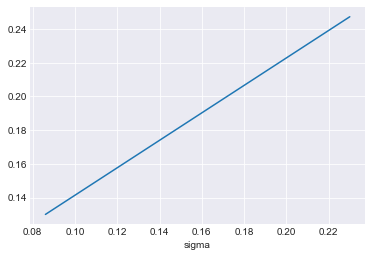

In [54]:
CML = pd.concat([pd.DataFrame(sigmas),pd.DataFrame(mus)], axis=1) 
CML.columns = ["sigma","mu"]
CML.plot.line(x="sigma", y="mu", grid=True, legend=False)
plt.show()